<a href="https://colab.research.google.com/github/GalBuzi/colab/blob/main/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
from google.colab import files

import os
import nltk
import pandas as pd
import numpy as np
import string
import pprint
import matplotlib.pyplot as plt
import re
import operator
from collections import Counter, OrderedDict
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer



drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


**Read Data and split it :**

In [48]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

# csv_file = pd.read_csv("gdrive/My Drive/small_imdb_data.csv")
csv_file = pd.read_csv("gdrive/My Drive/IMDB Dataset.csv")

nltk_stop_words = stopwords.words('english')

print(csv_file.shape[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
50000


**Data Prepartion:**

In [49]:
def clean_and_normalize_review_text(review):
    # remove tags
    clean_tags = re.compile('<.*?>')
    re_negation = re.compile("n't ")
    tokens1 = re.sub(clean_tags, '', review)
    tokens1 = re_negation.sub(" not ", tokens1)

    # split into words
    tokens2 = word_tokenize(tokens1)

    # convert to lower case
    tokens3 = [w.lower() for w in tokens2]

    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens4 = [w.translate(table) for w in tokens3]

    # remove remaining tokens that are not alphabetic
    tokens5 = [word for word in tokens4 if word != ' ' and all(x.isalpha() or x.isspace() for x in word)]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    # tokens6 = [w for w in tokens5 if w not in stop_words]
    tokens6 = []
    for w in tokens5:
        check = w.split(' ')
        if len(check) == 1:
            if w not in stop_words:
                tokens6.append(w)
        elif len(check) == 2: 
            if check[0] in stop_words and check[1] in stop_words:
                continue
            else:
                tokens6.append(w)


    # lemmatization
    lemma = WordNetLemmatizer()
    tokens7 = [lemma.lemmatize(word) for word in tokens6]
    tokens7 = ' '.join(tokens7)
    # create bi-grams
    bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
    analyze = bigram_vectorizer.build_analyzer()
    tokens8 = analyze(tokens7)

    return tokens8

In [50]:
# cleaning data text
for index, row in csv_file.iterrows():
  csv_file.loc[index,'review'] = clean_and_normalize_review_text(row['review'])
  csv_file.loc[index,'review_text'] = ' '.join( csv_file.loc[index,'review'] )

# train_data.drop('review', axis='columns', inplace=True)


In [51]:
# Explore train set reviews:

train_sentiment = csv_file['sentiment'].to_frame(name='sentiment')

#number of positive/negative reviews in train set:
pos_count = train_sentiment[train_sentiment['sentiment'] == 'positive'].count()
neg_count = train_sentiment[train_sentiment['sentiment'] == 'negative'].count()
print("number of positive reviews in train set: " + str(pos_count))
print("number of negative reviews in train set: " + str(neg_count))



number of positive reviews in train set: sentiment    25000
dtype: int64
number of negative reviews in train set: sentiment    25000
dtype: int64


In [52]:
# creating positive and negative dataframes from the train set
positive_reviews_train = csv_file[csv_file['sentiment'] == 'positive']
negative_reviews_train = csv_file[csv_file['sentiment'] == 'negative']
positive_reviews_train

,review,sentiment,review_text
0,"[one, reviewer, mentioned, watching, oz, episo...",positive,one reviewer mentioned watching oz episode hoo...
1,"[wonderful, little, production, filming, techn...",positive,wonderful little production filming technique ...
2,"[thought, wonderful, way, spend, time, hot, su...",positive,thought wonderful way spend time hot summer we...
4,"[petter, mattei, love, time, money, visually, ...",positive,petter mattei love time money visually stunnin...
5,"[probably, alltime, favorite, movie, story, se...",positive,probably alltime favorite movie story selfless...
...,...,...,...
49983,"[loved, fan, original, series, always, wondere...",positive,loved fan original series always wondered back...
49985,"[imaginary, hero, clearly, best, film, year, c...",positive,imaginary hero clearly best film year complete...
49989,"[got, one, week, ago, love, modern, light, fil...",positive,got one week ago love modern light filled true...
49992,"[john, garfield, play, marine, blinded, grenad...",positive,john garfield play marine blinded grenade figh...


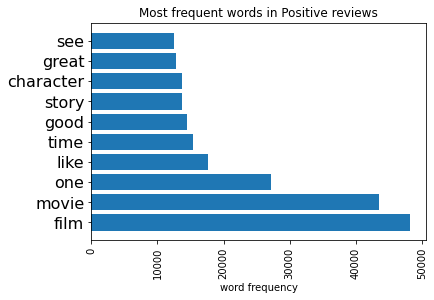

In [53]:
# show top 10 terms in positive reviews
corpus_pos = list(positive_reviews_train['review'])
dict_words = {}
for doc in corpus_pos:
  for word in doc:
    if word in dict_words.keys():
      dict_words[word] = dict_words[word] + 1
    else:
      dict_words[word] = 1

dict_words_top10 = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words_top10 = dict_words_top10[:10]
plt.barh(*zip(*dict_words_top10))
plt.title('Most frequent words in Positive reviews')
plt.xlabel('word frequency')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=16)
plt.show()

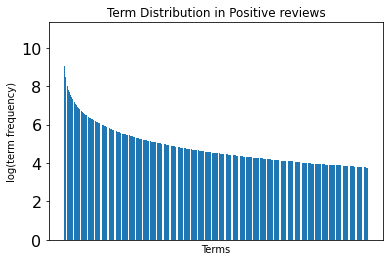

In [54]:
# Term Distribution - Positive - highest 10K terms

import math
dict_words = {k: math.log(v) for k, v in dict_words.items()}
dict_words = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words = dict_words[:10000]

plt.bar(*zip(*dict_words))
plt.title('Term Distribution in Positive reviews')
plt.xlabel('Terms')
plt.ylabel('log(term frequency)')
plt.xticks([], [])
plt.yticks(fontsize=16)
plt.show()

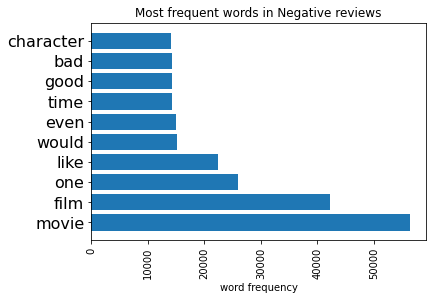

In [55]:
# show top 10 terms in negative reviews

corpus_neg = list(negative_reviews_train['review'])
dict_words = {}
for doc in corpus_neg:
  for word in doc:
    if word in dict_words.keys():
      dict_words[word] = dict_words[word] + 1
    else:
      dict_words[word] = 1

dict_words_top10 = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words_top10 = dict_words_top10[:10]
plt.barh(*zip(*dict_words_top10))
plt.title('Most frequent words in Negative reviews')
plt.xlabel('word frequency')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=16)
plt.show()

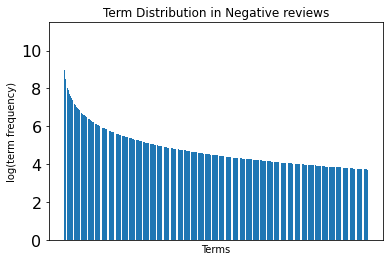

In [56]:
# Term Distribution - Negative - highest 10K terms

import math
dict_words = {k: math.log(v) for k, v in dict_words.items()}
dict_words = sorted(dict_words.items(), key=operator.itemgetter(1),reverse=True)
dict_words = dict_words[:10000]

plt.bar(*zip(*dict_words))
plt.title('Term Distribution in Negative reviews')
plt.xlabel('Terms')
plt.ylabel('log(term frequency)')
plt.xticks([], [])
plt.yticks(fontsize=16)
plt.show()

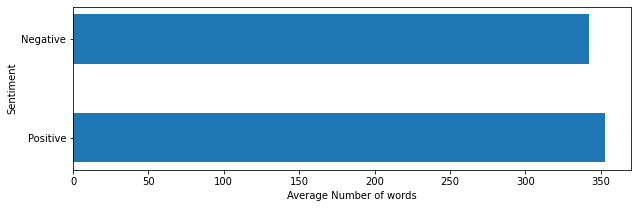

In [57]:
# Get mean of positive and negative reviews
avg_pos_reviews = csv_file[csv_file.sentiment=='positive'].review_text.apply(lambda x: len(x.split())).mean()
avg_neg_reviews = csv_file[csv_file.sentiment=='negative'].review_text.apply(lambda x: len(x.split())).mean()

plt.figure(figsize=(10, 3))
plt.barh(['Positive', 'Negative'], [avg_pos_reviews, avg_neg_reviews], height=0.5)
# plt.xticks(np.arange(0, 300, 25))
plt.xlabel('Average Number of words')
plt.ylabel('Sentiment')
plt.show()

Explain expected challenges:
1. as we can see from both graphs, the unigrams and bigrams are quite similar because the reviewers tend to mention words related to the movies and the story more often
2. each reviewer has his own opinion about the movie and uses different vocabulary to describe his thoughts and feelings which makes it difficult for us to find common and similar descripsions.
3. we can see that in the negative reviews that both 'bad' and 'good' are very common, which is very confusing to understand and decide whether the review is positive or negative
4. positive reviews has the same length as negative reviews in average numnber of words - we can't say that positive review suppose to be longer, same about negative review


# Q2:

In [58]:
# split=int(0.5*csv_file.shape[0])
# train_data = csv_file[0:split]
# test_data = csv_file[split:]
# train_data

# split to train and test
y = csv_file.sentiment
x = csv_file.drop('sentiment', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
train_data = x_train.merge(y_train, left_index=True, right_index=True)
test_data = x_test.merge(y_test, left_index=True, right_index=True)
test_data

,review,review_text,sentiment
1164,"[begotten, one, unique, film, ever, seen, stud...",begotten one unique film ever seen study sound...,positive
24130,"[short, part, four, short, cinema, journal, fi...",short part four short cinema journal film rent...,positive
44718,"[everything, film, terrible, start, film, pret...",everything film terrible start film pretty goo...,negative
15205,"[first, found, brian, krause, going, movie, wa...",first found brian krause going movie wanted wa...,positive
10628,"[one, cassavetes, best, performance, entire, c...",one cassavetes best performance entire cast ou...,positive
...,...,...,...
14943,"[guess, comment, upon, flick, magnificent, sev...",guess comment upon flick magnificent seven fra...,negative
32137,"[saw, movie, part, billy, graham, program, chu...",saw movie part billy graham program church att...,negative
40470,"[nyt, review, say, sigourney, weaver, characte...",nyt review say sigourney weaver character taut...,positive
43092,"[everybody, love, see, really, bad, movie, som...",everybody love see really bad movie sometime w...,negative


In [59]:
tagged_list = []

review_text_sentences = list(test_data['review_text'])
print(review_text_sentences[0])
stokens = [nltk.word_tokenize(sentence) for sentence in review_text_sentences]

for stoken in stokens:        
     tagged_list.append(nltk.pos_tag(stoken))

# tagged_list

begotten one unique film ever seen study sound light dark movement real story type thing see video instillation museum modern art film enjoyed local theater going try interpret image mother nature beast cloak twisted tortured body child thing defy interpretation begotten one one unique unique film film ever ever seen seen study study sound sound light light dark dark movement movement real real story story type type thing thing see see video video instillation instillation museum museum modern modern art art film film enjoyed enjoyed local local theater theater going going try try interpret interpret image image mother mother nature nature beast beast cloak cloak twisted twisted tortured tortured body body child child thing thing defy defy interpretation


In [60]:
from nltk.corpus import sentiwordnet as swn

lemmatizer_obj = nltk.WordNetLemmatizer()
score_list=[]

for idx,taggedsent in enumerate(tagged_list):  #iterate over all tokens
    score_list.append([])
    for idx2,t in enumerate(taggedsent):  #t[0] word, t[1] pos tag
        newtag=''
        lemmatized=lemmatizer_obj.lemmatize(t[0])
        if t[1].startswith('NN'):
            newtag='n'
        elif t[1].startswith('JJ'):
            newtag='a'
        elif t[1].startswith('V'):
            newtag='v'
        elif t[1].startswith('R'):
            newtag='r'
        else:
            newtag=''       
        if newtag!='' :    
            synsets = list(swn.senti_synsets(lemmatized, newtag))
            # print(lemmatized) # great
            # print(synsets) # [SentiSynset('great.s.01'), SentiSynset('great.s.02'), SentiSynset('great.s.03'), SentiSynset('bang-up.s.01'), SentiSynset('capital.s.03'), SentiSynset('big.s.13')]
            #synsets contains for each token the probability for negative, positive and objective
            #Getting average of all possible sentiments, as you requested        
            score=0
            if len(synsets)>0 :
                for syn in synsets:
                    # print("positive score ",syn.pos_score(),"negative score ",syn.neg_score(),"objective score ",syn.obj_score())
                    score+=syn.pos_score()-syn.neg_score()
                score_list[idx].append(score/len(synsets))


In [61]:
sentence_sentiment=[]

for score_sent in score_list:
  sum_sentence_score = sum(score_sent)   
  if len(score_sent) > 0:
    sentence_sentiment.append(sum_sentence_score/len(score_sent))
  else:
    sentence_sentiment.append(0)



In [62]:
test_data['review_score'] = sentence_sentiment
test_data

,review,review_text,sentiment,review_score
1164,"[begotten, one, unique, film, ever, seen, stud...",begotten one unique film ever seen study sound...,positive,0.006609
24130,"[short, part, four, short, cinema, journal, fi...",short part four short cinema journal film rent...,positive,0.002368
44718,"[everything, film, terrible, start, film, pret...",everything film terrible start film pretty goo...,negative,-0.005976
15205,"[first, found, brian, krause, going, movie, wa...",first found brian krause going movie wanted wa...,positive,0.076889
10628,"[one, cassavetes, best, performance, entire, c...",one cassavetes best performance entire cast ou...,positive,0.080063
...,...,...,...,...
14943,"[guess, comment, upon, flick, magnificent, sev...",guess comment upon flick magnificent seven fra...,negative,-0.019213
32137,"[saw, movie, part, billy, graham, program, chu...",saw movie part billy graham program church att...,negative,0.029886
40470,"[nyt, review, say, sigourney, weaver, characte...",nyt review say sigourney weaver character taut...,positive,0.035272
43092,"[everybody, love, see, really, bad, movie, som...",everybody love see really bad movie sometime w...,negative,0.002829


In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix

def set_sentiment(c):
  if c['review_score'] < 0.0:
    return 'negative'
  elif c['review_score'] > 0.0:
    return 'positive'

test_data['sentiment_pred'] = test_data.apply(set_sentiment , axis=1)
print("accuracy:")
print(accuracy_score(test_data['sentiment'] , test_data['sentiment_pred']))
con_mat = confusion_matrix(test_data['sentiment'] , test_data['sentiment_pred'], labels=['positive','negative'])
df = pd.DataFrame(con_mat , index=['positive','negative'] , columns=['positive','negative'])
print("confusion matrix:")
print(df)

accuracy:
0.64084
confusion matrix:
          positive  negative
positive     11242      1302
negative      7677      4779
